In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import DataSplitter

In [2]:
df60 = DataSplitter.getTrainData(60)

target_column = "diff"
drop_cols = ["date", "hour", "year", "quarter", "Q1", "month", "monthNumber", "weekNumber", "weekDay", "dateNumber", "mon", "workdayPlan", "line", "passengersBoarding", "datetime", "eventName"]

train60, val60 = DataSplitter.performTrainValSplit(df60)
train60_1A = train60[train60["line"] == "1A"]
val60_1A = val60[val60["line"] == "1A"]

X_train = train60_1A.drop(columns=([target_column] + drop_cols), axis=1).reset_index(drop=True)
X_val = val60_1A.drop(columns=([target_column] + drop_cols), axis=1).reset_index(drop=True)
y_train = train60_1A[target_column].reset_index(drop=True)
y_val = val60_1A[target_column].reset_index(drop=True)

In [3]:
batchSize = 16

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values)

trainDataset = TensorDataset(X_train_tensor, y_train_tensor)
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=False)

valDataset = TensorDataset(X_val_tensor, y_val_tensor)
valLoader = DataLoader(valDataset, batch_size=batchSize, shuffle=False)

In [4]:
def evaluation(model, loader, loss_fn, device):
    model.eval()
    total_loss = []
    with torch.no_grad():
        for batch_idx, (Xbatch, ybatch) in enumerate(loader):
            Xbatch = Xbatch.to(device)
            ybatch = ybatch.to(device)
            
            predictions = model(Xbatch)

            loss = loss_fn(predictions, ybatch)
            total_loss.append(loss.item())
    return np.mean(total_loss)

In [5]:
if torch.cuda.is_available():
    print("cuda")
    device = torch.device("cuda")
else:
    print("cpu")
    device = torch.device("cpu")

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=52, hidden_layer_size=100, output_size=1, batch_size=16):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, self.batch_size, self.hidden_layer_size),
                            torch.zeros(1, self.batch_size, self.hidden_layer_size))
    
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

cuda


In [7]:
model = LSTM()
totalEpochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="mean")

train_loss_list = []
val_loss_list = []
nEpochs = range(1, totalEpochs + 1)
for epoch in nEpochs:
    model.train()
    total_loss = []
    for batch_idx, (Xbatch, ybatch) in enumerate(trainLoader):
        Xbatch = Xbatch.to(device)
        ybatch = ybatch.to(device)

        optimizer.zero_grad()
        model = model.to(device)
        model.hidden_cell = (torch.zeros(1, Xbatch.size(0), model.hidden_layer_size).to(device),
                             torch.zeros(1, Xbatch.size(0), model.hidden_layer_size).to(device))

        predictions = model(Xbatch)

        loss = criterion(predictions, ybatch)
        loss.backward()

        optimizer.step()

        total_loss.append(loss.item())

    val_loss_mean = evaluation(model, valLoader, criterion, device)

    total_loss_mean = np.mean(total_loss)
    train_loss_list.append(total_loss_mean)
    val_loss_list.append(val_loss_mean)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Train Loss: {total_loss_mean}, Val Loss: {val_loss_mean}")

train_loss_list = np.array(train_loss_list)
val_loss_list = np.array(val_loss_list)
np.save(train_loss_list, "train_loss.npy")
np.save(val_loss_list, "val_loss.npy")

RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

In [ ]:
import matplotlib.pyplot as plt

plt.plot(nEpochs, train_loss_list, "b", label="Training Loss")
plt.plot(nEpochs, val_loss_list, "orange", label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

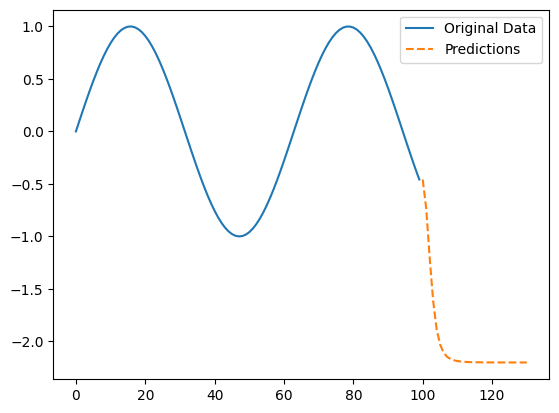

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt

plt.plot(df['value'], label='Original Data')
plt.plot(np.arange(len(df), len(df) + future + 1), predicted_data, label='Predictions', linestyle='dashed')
plt.legend()
plt.show()